In [29]:
import pandas as pd
import plotly.graph_objects as go
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import plotly.express as px
import plotly.io as pio
from textblob import TextBlob
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
pio.templates.default = "plotly_white"

In [3]:
df = pd.read_csv("chatgpt_reviews.csv")
df.head()

Review Id  \
0  6fb93778-651a-4ad1-b5ed-67dd0bd35aac   
1  81caeefd-3a28-4601-a898-72897ac906f5   
2  452af49e-1d8b-4b68-b1ac-a94c64cb1dd5   
3  372a4096-ee6a-4b94-b046-cef0b646c965   
4  b0d66a4b-9bde-4b7c-8b11-66ed6ccdd7da   

                                              Review  Ratings  \
0                                               good        5   
1                                               good        5   
2                                           nice app        5   
3                                           nice, ig        5   
4  this is a great app, the bot is so accurate to...        5   

           Review Date  
0  2024-08-23 19:30:05  
1  2024-08-23 19:28:18  
2  2024-08-23 19:22:59  
3  2024-08-23 19:20:50  
4  2024-08-23 19:20:39

In [5]:
df.isnull().sum()

Review Id      0
Review         6
Ratings        0
Review Date    0
dtype: int64

In [7]:
df['Review'] = df['Review'].astype(str).fillna('')

In [9]:
df = df[df['Review'].apply(lambda x: len(x.split()) < 500)] 

In [11]:
def get_sentiment(review):
    sentiment = TextBlob(review).sentiment.polarity
    if sentiment > 0:
        return 'Positive'
    elif sentiment < 0:
        return 'Negative'
    else:
        return 'Neutral'

In [13]:
df['Sentiment'] = df['Review'].apply(get_sentiment)

In [15]:
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['Review'])

In [17]:
y = df['Sentiment'].apply(lambda x: 1 if x == 'Positive' else (0 if x == 'Neutral' else -1)) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [19]:
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

In [58]:
y_pred = model.predict(X_test)
print("Model Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Model Accuracy: 0.8170928006235281

Classification Report:
               precision    recall  f1-score   support

          -1       0.92      0.05      0.09      2403
           0       0.91      0.29      0.44     11628
           1       0.81      0.99      0.89     44988

    accuracy                           0.82     59019
   macro avg       0.88      0.44      0.47     59019
weighted avg       0.83      0.82      0.77     59019



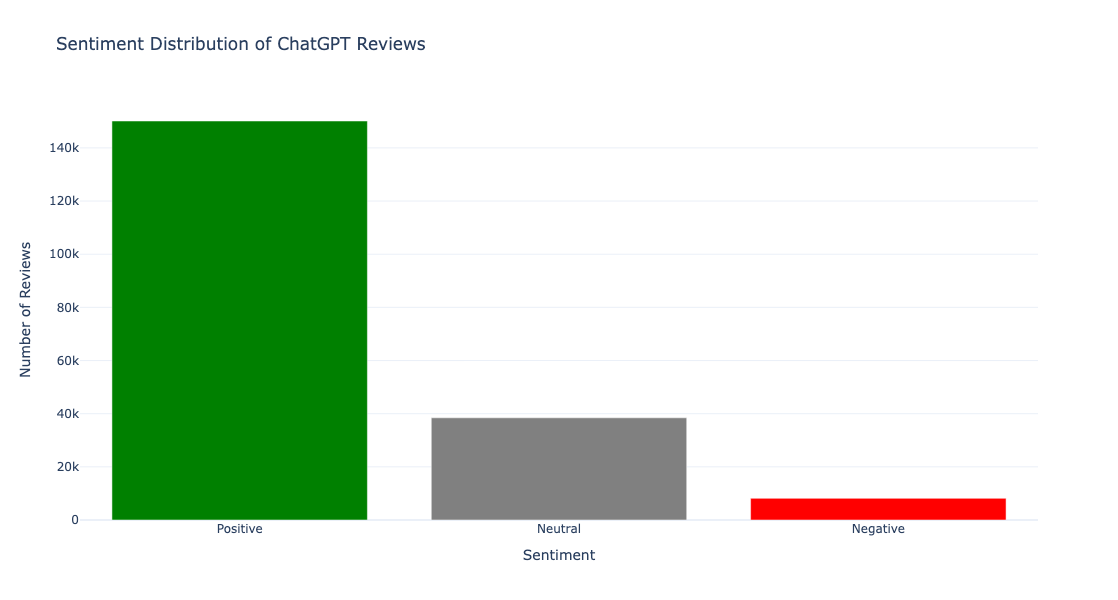

In [23]:
sentiment_distribution = df['Sentiment'].value_counts()
fig = go.Figure(data=[go.Bar(
    x=sentiment_distribution.index,
    y=sentiment_distribution.values,
    marker_color=['green', 'gray', 'red'],
)])
fig.update_layout(
    title='Sentiment Distribution of ChatGPT Reviews',
    xaxis_title='Sentiment',
    yaxis_title='Number of Reviews',
    width=800,
    height=600
)
fig.show()

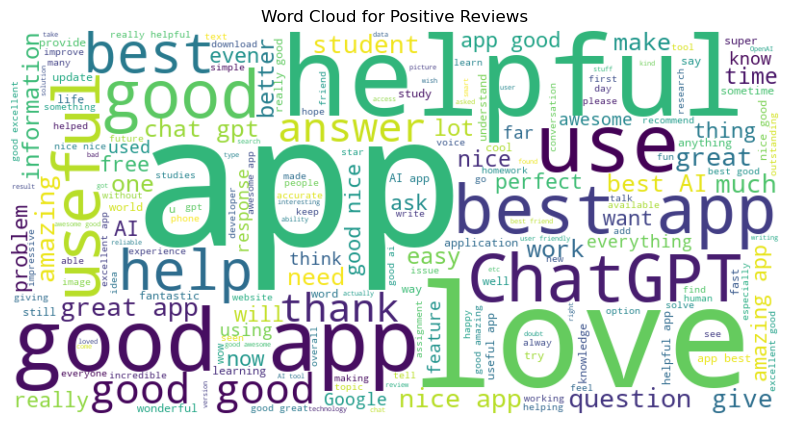

In [31]:
positive_reviews = df[df['Sentiment'] == 'Positive']['Review'].str.cat(sep=' ')
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)
plt.figure(figsize=(10, 5))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Reviews')
plt.show()

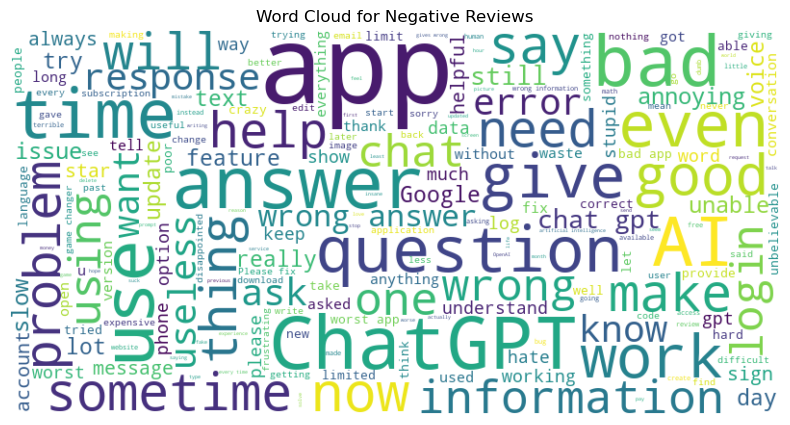

In [33]:
negative_reviews = df[df['Sentiment'] == 'Negative']['Review'].str.cat(sep=' ')
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)
plt.figure(figsize=(10, 5))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Reviews')
plt.show()

In [35]:
positive_reviews = df[df['Sentiment'] == 'Positive']['Review']
vectorizer = CountVectorizer(ngram_range=(2, 3), stop_words='english', max_features=100)
X = vectorizer.fit_transform(positive_reviews)

In [37]:
phrase_counts = X.sum(axis=0)
phrases = vectorizer.get_feature_names_out()
phrase_freq = [(phrases[i], phrase_counts[0, i]) for i in range(len(phrases))]

In [39]:
phrase_freq = sorted(phrase_freq, key=lambda x: x[1], reverse=True)
phrase_df = pd.DataFrame(phrase_freq, columns=['Phrase', 'Frequency'])

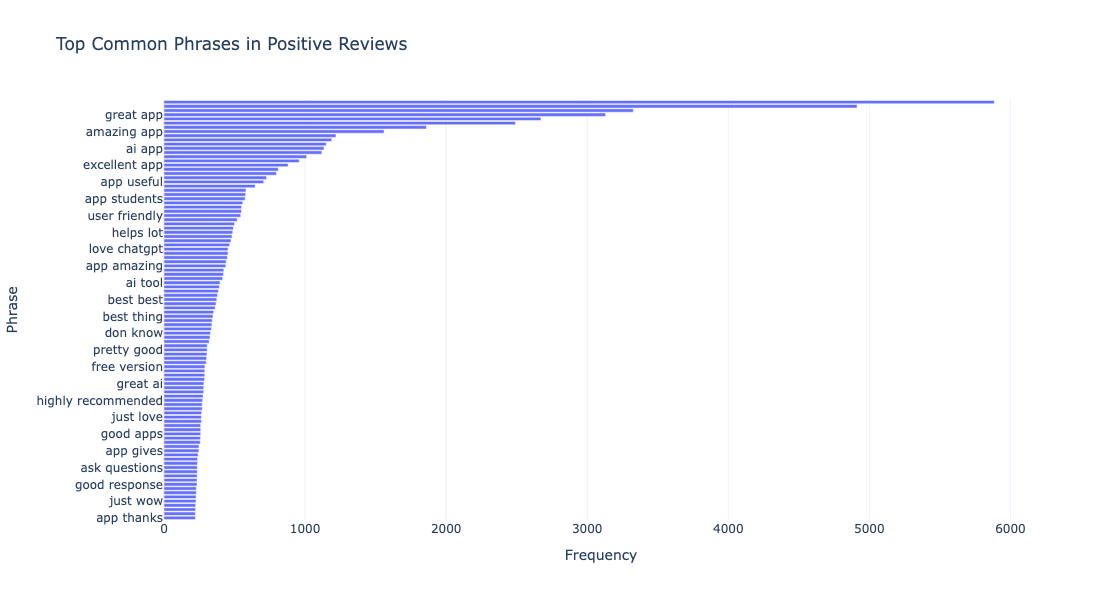

In [41]:
fig = px.bar(phrase_df,
             x='Frequency',
             y='Phrase',
             orientation='h',
             title='Top Common Phrases in Positive Reviews',
             labels={'Phrase': 'Phrase', 'Frequency': 'Frequency'},
             width=1000,
             height=600)
fig.update_layout(
    xaxis_title='Frequency',
    yaxis_title='Phrase',
    yaxis={'categoryorder': 'total ascending'}
)
fig.show()

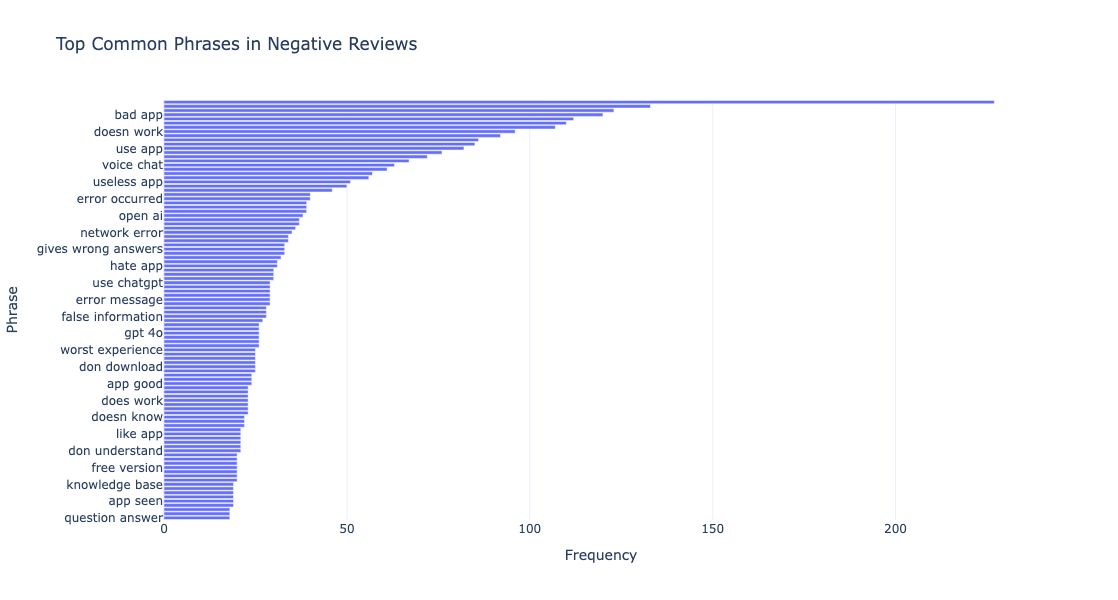

In [43]:
negative_reviews = df[df['Sentiment'] == 'Negative']['Review']
X_neg = vectorizer.fit_transform(negative_reviews)

# Sum counts of each phrase in negative reviews
phrase_counts_neg = X_neg.sum(axis=0)
phrases_neg = vectorizer.get_feature_names_out()
phrase_freq_neg = [(phrases_neg[i], phrase_counts_neg[0, i]) for i in range(len(phrases_neg))]

# Sort phrases by frequency
phrase_freq_neg = sorted(phrase_freq_neg, key=lambda x: x[1], reverse=True)
phrase_neg_df = pd.DataFrame(phrase_freq_neg, columns=['Phrase', 'Frequency'])

# Plot top common phrases in negative reviews
fig = px.bar(phrase_neg_df,
             x='Frequency',
             y='Phrase',
             orientation='h',
             title='Top Common Phrases in Negative Reviews',
             labels={'Phrase': 'Phrase', 'Frequency': 'Frequency'},
             width=1000,
             height=600)
fig.update_layout(
    xaxis_title='Frequency',
    yaxis_title='Phrase',
    yaxis={'categoryorder': 'total ascending'}
)
fig.show()

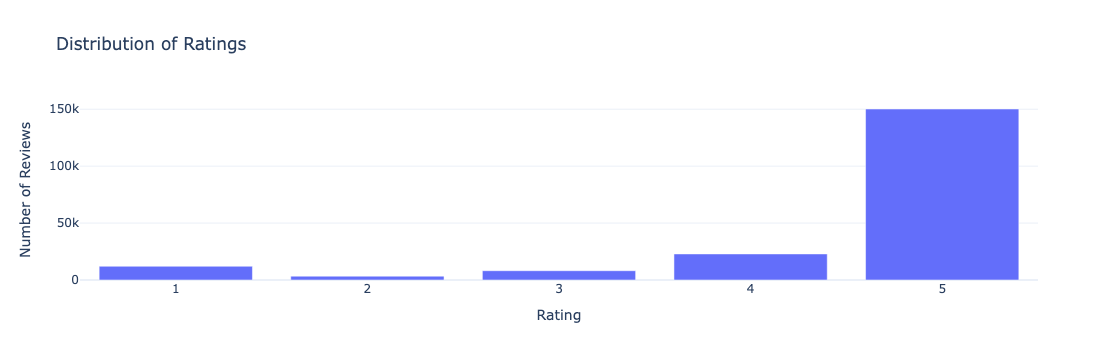

In [47]:
rating_dist = df['Ratings'].value_counts().sort_index()

fig = px.bar(rating_dist, x=rating_dist.index, y=rating_dist.values, 
             title='Distribution of Ratings', labels={'x': 'Rating', 'y': 'Number of Reviews'})
fig.update_layout(
    plot_bgcolor='white',
    xaxis_title='Rating',
    yaxis_title='Number of Reviews'
)
fig.show()

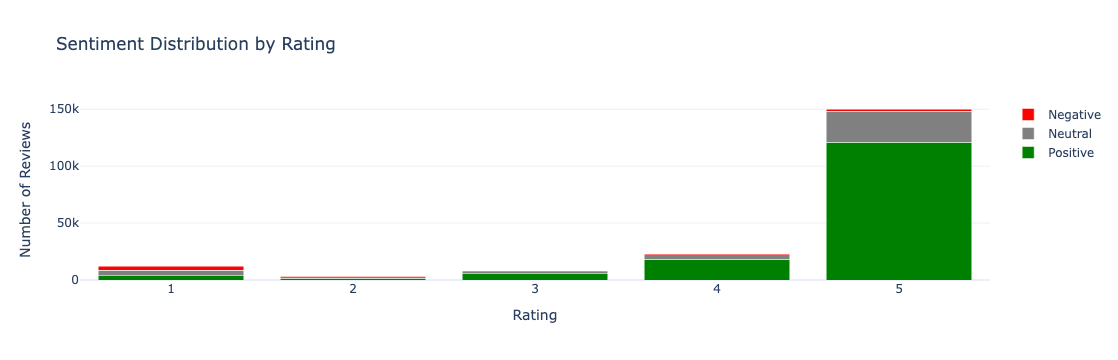

In [49]:
sentiment_rating = df.groupby(['Ratings', 'Sentiment']).size().unstack(fill_value=0)

# Plot sentiment by rating
fig = go.Figure(data=[
    go.Bar(x=sentiment_rating.index, y=sentiment_rating['Positive'], name='Positive', marker_color='green'),
    go.Bar(x=sentiment_rating.index, y=sentiment_rating['Neutral'], name='Neutral', marker_color='gray'),
    go.Bar(x=sentiment_rating.index, y=sentiment_rating['Negative'], name='Negative', marker_color='red')
])
fig.update_layout(
    title='Sentiment Distribution by Rating',
    xaxis_title='Rating',
    yaxis_title='Number of Reviews',
    barmode='stack',
    plot_bgcolor='white'
)
fig.show()

In [54]:
problem_keywords = {
    'Incorrect Answers': ['wrong answer', 'gives wrong', 'incorrect', 'inaccurate', 'wrong'],
    'App Performance': ['slow', 'lag', 'crash', 'bug', 'freeze', 'loading', 'glitch', 'worst app', 'bad app', 'horrible', 'terrible'],
    'User Interface': ['interface', 'UI', 'difficult to use', 'confusing', 'layout'],
    'Features Missing/Not Working': ['feature missing', 'not working', 'missing', 'broken', 'not available'],
    'Quality of Responses': ['bad response', 'useless', 'poor quality', 'irrelevant', 'nonsense']
}

# Initialize dictionary to count problems
problem_counts = {key: 0 for key in problem_keywords.keys()}

# Count occurrences of problem-related phrases in negative reviews
for phrase, count in phrase_freq_neg:
    for problem, keywords in problem_keywords.items():
        if any(keyword in phrase for keyword in keywords):
            problem_counts[problem] += count
            break

# Prepare the problem counts DataFrame
problem_df = pd.DataFrame(list(problem_counts.items()), columns=['Problem', 'Frequency'])

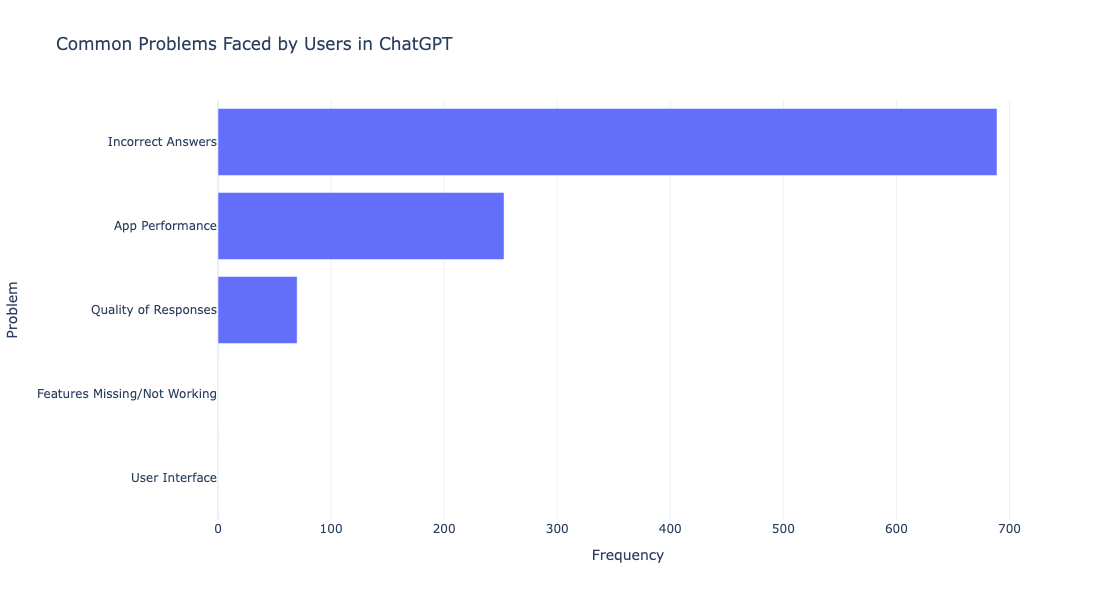

In [56]:
fig = px.bar(problem_df,
             x='Frequency',
             y='Problem',
             orientation='h',
             title='Common Problems Faced by Users in ChatGPT',
             labels={'Problem': 'Problem', 'Frequency': 'Frequency'},
             width=1000,
             height=600)
fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    xaxis_title='Frequency',
    yaxis_title='Problem',
    yaxis={'categoryorder': 'total ascending'}
)
fig.show()

In [60]:
df['Review Date'] = pd.to_datetime(df['Review Date'])
sentiment_over_time = df.groupby([df['Review Date'].dt.to_period('M'), 'Sentiment']).size().unstack(fill_value=0)
sentiment_over_time.index = sentiment_over_time.index.to_timestamp()

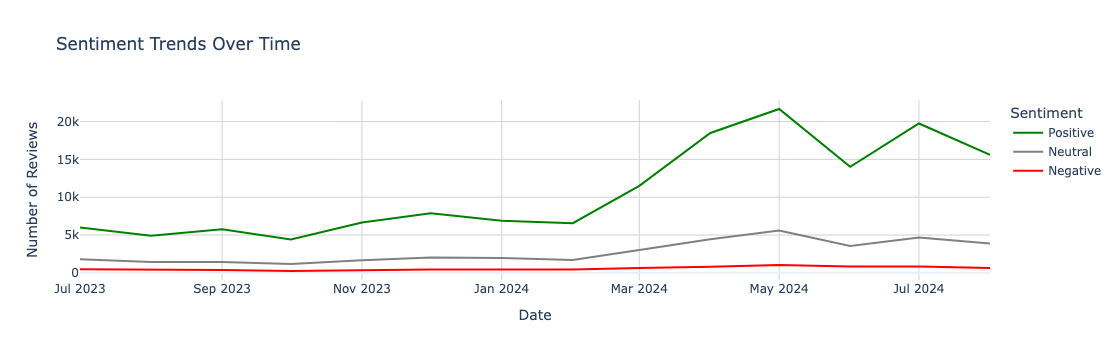

In [62]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=sentiment_over_time.index, y=sentiment_over_time['Positive'],
                         mode='lines', name='Positive', line=dict(color='green')))
fig.add_trace(go.Scatter(x=sentiment_over_time.index, y=sentiment_over_time['Neutral'],
                         mode='lines', name='Neutral', line=dict(color='gray')))
fig.add_trace(go.Scatter(x=sentiment_over_time.index, y=sentiment_over_time['Negative'],
                         mode='lines', name='Negative', line=dict(color='red')))
fig.update_layout(
    title='Sentiment Trends Over Time',
    xaxis_title='Date',
    yaxis_title='Number of Reviews',
    plot_bgcolor='white',
    paper_bgcolor='white',
    legend_title_text='Sentiment',
    xaxis=dict(showgrid=True, gridcolor='lightgray'),
    yaxis=dict(showgrid=True, gridcolor='lightgray')
)
fig.show()

In [64]:
df['NPS Category'] = df['Ratings'].apply(lambda x: 'Promoter' if x == 5 else ('Passive' if x == 4 else 'Detractor'))
nps_counts = df['NPS Category'].value_counts(normalize=True) * 100
nps_score = nps_counts.get('Promoter', 0) - nps_counts.get('Detractor', 0)

# Display the NPS score
print("NPS Score:", nps_score)

NPS Score: 64.35313912172705


In [1]:
pwd

'/Users/anand'